c:\Users\pishva_r\Anaconda3\envs\test2\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
C:\Users\pishva_r\AppData\Local\Temp\ipykernel_11032\3613274830.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_filtered = df_filtered.set_index('DateTime').resample('1H').mean()
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricColl

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE: 3.15
MAE: 2.44


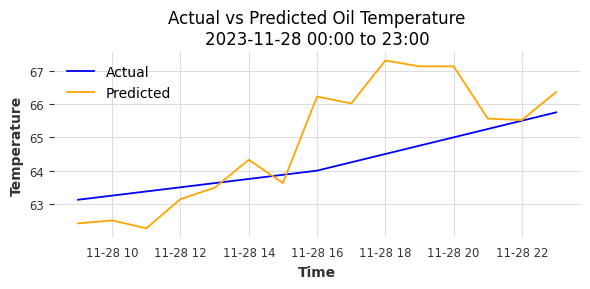

In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.metrics import rmse, mae
import matplotlib.pyplot as plt

# 1. خواندن داده
df = pd.read_excel("main_trans.xlsx")
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.dropna(subset=['DateTime'])

# 2. فیلتر بازه زمانی
target_date = pd.to_datetime('2023-9-01 00:00:00')
df_filtered = df[df['DateTime'] >= target_date]

# 3. بازنمونه‌گیری و پر کردن داده‌های خالی
df_filtered = df_filtered.set_index('DateTime').resample('1H').mean()
df_filtered = df_filtered.interpolate(method='linear')

# 4. ساخت سری هدف و covariates
series = TimeSeries.from_dataframe(df_filtered, value_cols='oil temperature', freq='h')
covariates = TimeSeries.from_dataframe(df_filtered, value_cols=['winding temperature', 'tap position'], freq='h')

# 5. نرمال‌سازی
scaler_series = Scaler(MinMaxScaler())
series_scaled = scaler_series.fit_transform(series)

scaler_cov = Scaler(MinMaxScaler())
covariates_scaled = scaler_cov.fit_transform(covariates)

# 6. تقسیم داده‌ها
train_ratio = 0.95
train_series, test_series = series_scaled.split_after(train_ratio)
train_cov, test_cov = covariates_scaled.split_after(train_ratio)

# 7. ساخت مدل N-BEATS
model = NBEATSModel(
    input_chunk_length=48,
    output_chunk_length=12,
    n_epochs=20,
    num_stacks=30,  # پارامتر پیش‌فرض، می‌تونید تیون کنید
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    batch_size=32,
    random_state=42,
    model_name="oil-temp-nbeats"
)

# 8. آموزش مدل
model.fit(series=train_series, past_covariates=train_cov, verbose=True)

# 9. پیش‌بینی
pred = model.predict(n=len(test_series), series=train_series, past_covariates=covariates_scaled)

# 10. بازگرداندن مقیاس اصلی
pred = scaler_series.inverse_transform(pred)
test_series = scaler_series.inverse_transform(test_series)

# 11. ارزیابی
print(f"RMSE: {rmse(test_series, pred):.2f}")
print(f"MAE: {mae(test_series, pred):.2f}")

# 12. تبدیل به DataFrame برای رسم
df_test = pd.DataFrame({'oil temperature': test_series.values().flatten()}, index=test_series.time_index)
df_pred = pd.DataFrame({'oil temperature': pred.values().flatten()}, index=pred.time_index)

# 13. رسم فقط یک روز از داده‌های تست و پیش‌بینی
start_time = df_test.index[0].replace(hour=0, minute=0, second=0)
end_time = start_time + pd.Timedelta(hours=23)

df_test_day = df_test[(df_test.index >= start_time) & (df_test.index <= end_time)]
df_pred_day = df_pred[(df_pred.index >= start_time) & (df_pred.index <= end_time)]

plt.figure(figsize=(6, 3))
plt.plot(df_test_day.index, df_test_day['oil temperature'], label='Actual', color='blue')
plt.plot(df_pred_day.index, df_pred_day['oil temperature'], label='Predicted', color='orange')
plt.legend()
plt.title(f"Actual vs Predicted Oil Temperature\n{start_time.date()} 00:00 to 23:00")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()
